# Time series
## Temperature prediction

In [2]:
with open('jena_climate_2009_2016.csv') as file:
    data = file.read()
len(data)

43153572

In [3]:
data[:300]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30\n01'

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [5]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    temp = [float(x) for x in line.split(',')[1:]]
    temperature[i] = temp[1]
    raw_data[i,:] = temp[:]

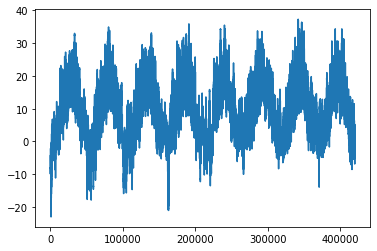

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)

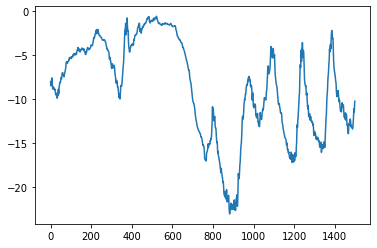

In [7]:
plt.plot(range(1500), temperature[:1500])

In [8]:
n_train = int(0.5*len(lines))
n_val = int(0.25*len(lines))
n_test = len(lines) - n_train -n_val
n_train, n_val, len(lines), n_test+ n_val+n_train

(210225, 105112, 420451, 420451)

Preparing the data

In [9]:
import numpy as np

mean = raw_data[:n_train].mean(axis=0)
std = raw_data[:n_train].std(axis=0)
raw_data = (raw_data-mean) / std

Dataset creating

In [10]:
# Example

from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length=3,
    batch_size=2
)

for input, target in dummy_dataset:
    for i in range(input.shape[0]):
        print([int(x) for x in input[i]], int(target[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [11]:
sampling_rate = 6 #Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
sequence_length = 120 #Observations will go back 5 days (120 hours).
delay = sampling_rate * (sequence_length + 24 - 1) #The target for a sequence will be the temperature 24 hours after the end of the sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=n_train + n_val
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train + n_val,
    )


Naive approach: temperature after 24 hour will be like now

In [12]:
def evaluate_naive_methof(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] +mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

print('Train MAE: ', evaluate_naive_methof(train_dataset))
print('Test MAE: ', evaluate_naive_methof(test_dataset))

Train MAE:  2.691671264784778
Test MAE:  2.621898451761208


Model

In [13]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 17s 20ms/step - loss: 13.3385 - mae: 2.8209 - val_loss: 13.1618 - val_mae: 2.8528
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 9.4427 - mae: 2.4187 - val_loss: 10.9563 - val_mae: 2.5989
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 8.7232 - mae: 2.3221 - val_loss: 11.5817 - val_mae: 2.7097
Epoch 4/10
819/819 [==============================] - 19s 24ms/step - loss: 8.2549 - mae: 2.2551 - val_loss: 10.6609 - val_mae: 2.5941
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.9074 - mae: 2.2071 - val_loss: 10.2778 - val_mae: 2.5395
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 7.6136 - mae: 2.1655 - val_loss: 10.4612 - val_mae: 2.5713
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 7.4018 - mae: 2.1368 - val_loss: 10.6896 - val_mae: 2.5969
Epoch 8/10
819/819 [==============================] - 

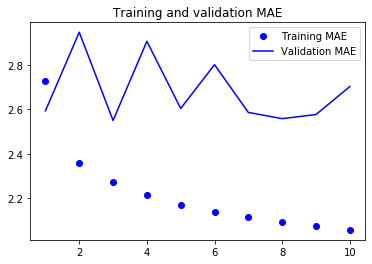

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

1D convolutional

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 8)             2696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 8)             776       
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 23s 27ms/step - loss: 23.2879 - mae: 3.8105 - val_loss: 19.2460 - val_mae: 3.4450
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 18.5685 - mae: 3.4112 - val_loss: 17.0408 - val_mae: 3.2700
Epoch 3/10
819/819 [==============================] - 22s 27ms/step - loss: 16.4887 - mae: 3.2098 - val_loss: 17.4777 - val_mae: 3.2838
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 15.2448 - mae: 3.0842 - val_loss: 16.2988 - val_mae: 3.2067
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 14.5133 - mae: 3.0082 - val_loss: 15.4380 - val_mae: 3.1174
Epoch 6/10
819/819 [==============================] - 21s 26ms/step - loss: 14.0496 - mae: 2.9611 - val_loss: 15.8683 - val_mae: 3.1546
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 13.6335 - mae: 2.9197 - val_loss: 15.4254 - val_mae: 3.1071
Epoch 8/10
819/819 [============================

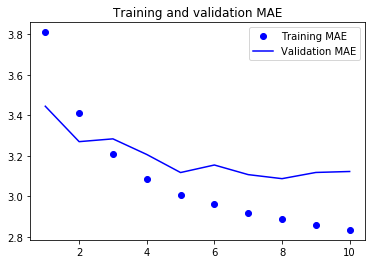

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

Reccurent model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1984      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 38.4753 - mae: 4.4927 - val_loss: 12.1682 - val_mae: 2.6544
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 10.8547 - mae: 2.5625 - val_loss: 9.7573 - val_mae: 2.4401
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 9.8366 - mae: 2.4424 - val_loss: 9.8317 - val_mae: 2.4448
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.3188 - mae: 2.3779 - val_loss: 9.9047 - val_mae: 2.4554
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9701 - mae: 2.3324 - val_loss: 10.1481 - val_mae: 2.4909
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.7446 - mae: 2.3034 - val_loss: 10.1025 - val_mae: 2.4824
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.5719 - mae: 2.2830 - val_loss: 10.1429 - val_mae: 2.4823
Epoch 8/10
819/819 [==============================] - 42

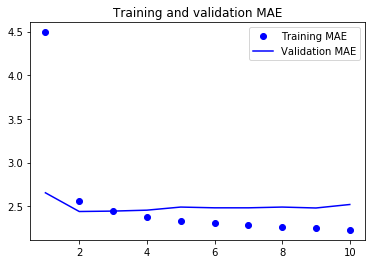

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

An RNN layer that can process sequences of any length

In [22]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

An RNN layer that returns only its last output step

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


An RNN layer that returns its full output sequence

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


Stacking RNN layers

In [25]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

### Dropout for RNN

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)]

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics='mae'
)

In [16]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 87s 104ms/step - loss: 26.6727 - mae: 3.8296 - val_loss: 10.5611 - val_mae: 2.5339
Epoch 2/50
819/819 [==============================] - 92s 112ms/step - loss: 14.7167 - mae: 2.9805 - val_loss: 9.3761 - val_mae: 2.3722
Epoch 3/50
819/819 [==============================] - 102s 124ms/step - loss: 13.8447 - mae: 2.8884 - val_loss: 9.3926 - val_mae: 2.3796
Epoch 4/50
819/819 [==============================] - 92s 113ms/step - loss: 13.2680 - mae: 2.8301 - val_loss: 9.0729 - val_mae: 2.3379
Epoch 5/50
819/819 [==============================] - 91s 111ms/step - loss: 12.8552 - mae: 2.7800 - val_loss: 9.4043 - val_mae: 2.3809
Epoch 6/50
819/819 [==============================] - 102s 124ms/step - loss: 12.4687 - mae: 2.7412 - val_loss: 9.5405 - val_mae: 2.4012
Epoch 7/50
819/819 [==============================] - 109s 133ms/step - loss: 12.2323 - mae: 2.7172 - val_loss: 9.4411 - val_mae: 2.3870
Epoch 8/50
819/819 [========================

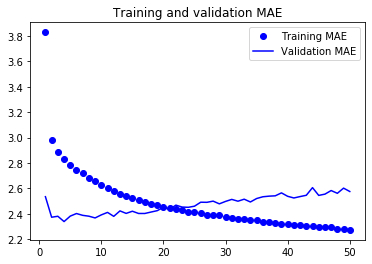

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

### Stacking recurrent layers

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
            keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
            save_best_only=True)
            ]

In [19]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 276s 328ms/step - loss: 24.6608 - mae: 3.6677 - val_loss: 9.6013 - val_mae: 2.3979
Epoch 2/50
819/819 [==============================] - 262s 320ms/step - loss: 13.9717 - mae: 2.8965 - val_loss: 9.1799 - val_mae: 2.3507
Epoch 3/50
819/819 [==============================] - 294s 358ms/step - loss: 13.2224 - mae: 2.8207 - val_loss: 9.4457 - val_mae: 2.3970
Epoch 4/50
819/819 [==============================] - 282s 344ms/step - loss: 12.7046 - mae: 2.7670 - val_loss: 8.6898 - val_mae: 2.2806
Epoch 5/50
819/819 [==============================] - 283s 345ms/step - loss: 12.3199 - mae: 2.7246 - val_loss: 8.4220 - val_mae: 2.2509
Epoch 6/50
819/819 [==============================] - 278s 339ms/step - loss: 11.8289 - mae: 2.6733 - val_loss: 8.9846 - val_mae: 2.3249
Epoch 7/50
819/819 [==============================] - 251s 306ms/step - loss: 11.4900 - mae: 2.6332 - val_loss: 9.0032 - val_mae: 2.3298
Epoch 8/50
819/819 [=====================

### Using bidirectional RNNs

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 84s 97ms/step - loss: 29.8168 - mae: 3.8900 - val_loss: 10.9376 - val_mae: 2.5510
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 9.6448 - mae: 2.4247 - val_loss: 9.3385 - val_mae: 2.3611
Epoch 3/10
819/819 [==============================] - 79s 96ms/step - loss: 8.5425 - mae: 2.2805 - val_loss: 9.5632 - val_mae: 2.3868
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 7.8955 - mae: 2.1921 - val_loss: 9.8803 - val_mae: 2.4197
Epoch 5/10
819/819 [==============================] - 81s 99ms/step - loss: 7.4990 - mae: 2.1343 - val_loss: 10.5001 - val_mae: 2.5030
Epoch 6/10
819/819 [==============================] - 81s 98ms/step - loss: 7.2144 - mae: 2.0931 - val_loss: 10.4235 - val_mae: 2.5002
Epoch 7/10
819/819 [==============================] - 82s 100ms/step - loss: 6.9763 - mae: 2.0574 - val_loss: 10.3727 - val_mae: 2.4960
Epoch 8/10
819/819 [==============================] - 81

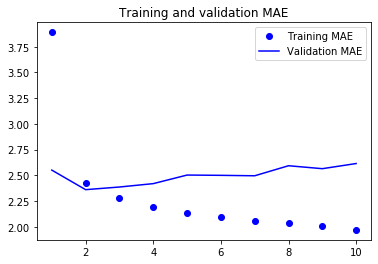

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()